
<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

## Deep Learning: Convolutional neural networks

This notebook shows three commonly used neural network architectures to train a model that can classify images of fingerprints.

Data source: JinZhuXing [Fingerprint Dataset for FVC2000_DB4_B in Kaggle](https://www.kaggle.com/peace1019/fingerprint-dataset-for-fvc2000-db4-b)

Useful Notebooks: 

[https://www.kaggle.com/code/peace1019/train-and-eval-20200410](https://www.kaggle.com/code/peace1019/train-and-eval-20200410)

[https://www.kaggle.com/code/sayeefmahmud/fingerprint-detector](https://www.kaggle.com/code/sayeefmahmud/fingerprint-detector)

Libraries for this worksheet:
- [Keras](https://keras.io/) is used as high-level API for [tensorflow](https://www.tensorflow.org/) backend
- PIL
- shutil (built in python library)
- collections
- sci-kit learn
- pydot (graphViz to print out the model layers)
- numpy
- matplotlib

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.applications import VGG16
from keras import layers, models,  regularizers, optimizers, callbacks
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.models import Sequential

#import pydot

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
import pickle
from PIL import Image
from collections import defaultdict
import shutil

import os
import datetime


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU: ", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.18.1
Eager mode:  True
GPU:  NOT AVAILABLE


In [6]:
import sys
sys.version

'3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42:21) [MSC v.1916 64 bit (AMD64)]'

# Load Data

1. Go into the ```../data/fingerprints/``` directory and extract the `.zip` file. This will result in a `train_data` directory that has a bunch of `.bmp` images (our raw data).  

The  .bmp files are named with a 4-digit ID for the person, followed by a two-digit sequence number pertaining to (likely) the finger number, though we don't know for sure so we will just treat it as a sequential ID. 
```
00001_04.bmp
00001_06.bmp
```


In [41]:
DATA_HOME = '../data/fingerprints'

# Path to dataset folder
TRAIN_DATA_RAW_PATH = os.path.join(DATA_HOME, "train_data")

In [42]:
# Dictionary to store the count of fingerprints per person
person_fingerprints = defaultdict(int)

# Iterate over files
for filename in os.listdir(TRAIN_DATA_RAW_PATH):
    if filename.endswith(".bmp"): 
        person_id = filename.split("_")[0]  # Extract the person ID 
        person_fingerprints[person_id] += 1

### Visualize Data

Image: ../data/fingerprints\train_data\00000_07.bmp, Dimensions: (160, 160)


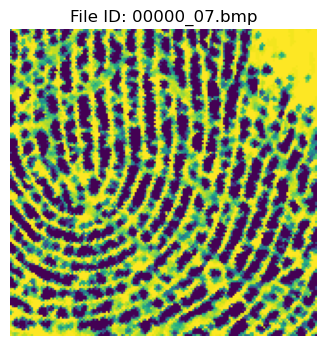

In [43]:
# Randomly sample and plot one of our raw data files
sample_images = []
for file_id in random.sample(os.listdir(TRAIN_DATA_RAW_PATH), 1):  
    img_path =  os.path.join(TRAIN_DATA_RAW_PATH, file_id) 

# Plot the fingerprint
plt.figure(figsize=(10, 10))
img = Image.open(img_path)
plt.subplot(3, 2, 1)
plt.imshow(img) #, cmap="gray")  # change to grayscale image, since that's what it is irl
plt.title(f"File ID: {file_id}")
plt.axis("off")
print(f"Image: {img_path}, Dimensions: {img.size}")  # Print dimensions

plt.tight_layout()
plt.show()

## Load Data part 2
In order to train the model, we will need to separate the raw files into a train/test/validation split. 
- The training data in **TRAIN_DATA_RAW_PATH**, will need to be organized by person in order to stratify our splits. 

In [44]:
# Organize fingerprint files by person
fingerprints_by_person = {}

# Create a dictionary that has each person's ID as the keys and a list of that persons filenames as the value
for filename in os.listdir(TRAIN_DATA_RAW_PATH):
    if filename.endswith(".bmp"):
        person_id = filename.split("_")[0]  # Extract the person ID
        if person_id not in fingerprints_by_person:
            fingerprints_by_person[person_id] = []
        fingerprints_by_person[person_id].append(filename)

In [46]:
# check our dict for one person
fingerprints_by_person['00001'][1:5]

['00001_01.bmp', '00001_02.bmp', '00001_03.bmp', '00001_04.bmp']

### Exercise 1a: Count the number of different people in this dataset, and their fingerprints

In [47]:
# Total number of unique persons
num_persons = len(fingerprints_by_person.keys())

print(f"Total number of persons: {num_persons}")
print("Number of fingerprints per person:")
for person_id, fp_list in fingerprints_by_person.items():
    print(f"Person {person_id}: {len(fp_list)} fingerprints")

Total number of persons: 10
Number of fingerprints per person:
Person 00000: 80 fingerprints
Person 00001: 80 fingerprints
Person 00002: 80 fingerprints
Person 00003: 80 fingerprints
Person 00004: 80 fingerprints
Person 00005: 80 fingerprints
Person 00006: 80 fingerprints
Person 00007: 80 fingerprints
Person 00008: 80 fingerprints
Person 00009: 80 fingerprints


## Train/Test/Validation split
We see that there are usually more than 10 files per person, so it's probably safe to assume that the sequence number does not map to anything.

Next we make the train/test/val split. When doing a multi-class problem like this, we want to make sure we get some data from each class into the train/test and validation datasets. So we need to iterate through each person in the dict and randomly pull out the following ratios:
```
train=70%
validation=15%
test=15%
```

In [48]:
# Output directories 
output_dir = os.path.normpath(os.path.join(DATA_HOME, "split_dataset"))
train_dir = os.path.normpath(os.path.join(output_dir, "train"))
val_dir = os.path.normpath(os.path.join(output_dir, "validation"))
test_dir = os.path.normpath(os.path.join(output_dir, "test"))

# Create directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    
# Split data into train/val/test for each person
split_ratios = (0.7, 0.15, 0.15)  # Training, Validation, Test

for person_id, files in fingerprints_by_person.items():
    train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)
    
    # Copy files to the corresponding directories
    for file_list, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
        person_dir = os.path.normpath(os.path.join(target_dir, person_id))
        os.makedirs(person_dir, exist_ok=True)
        for file_name in file_list:
            src_path = os.path.normpath(os.path.join(TRAIN_DATA_RAW_PATH, file_name))
            dest_path = os.path.normpath(os.path.join(person_dir, file_name))
            shutil.copy(src_path, dest_path)

print("Dataset successfully split into training, validation, and test sets.")

Dataset successfully split into training, validation, and test sets.


### Visualize Data
Let's look at a few samples for 3 people. 

Image: ..\data\fingerprints\split_dataset\train\00009\00009_76.bmp, Dimensions: (160, 160)
Image: ..\data\fingerprints\split_dataset\train\00009\00009_43.bmp, Dimensions: (160, 160)
Image: ..\data\fingerprints\split_dataset\train\00001\00001_23.bmp, Dimensions: (160, 160)
Image: ..\data\fingerprints\split_dataset\train\00001\00001_77.bmp, Dimensions: (160, 160)
Image: ..\data\fingerprints\split_dataset\train\00000\00000_29.bmp, Dimensions: (160, 160)
Image: ..\data\fingerprints\split_dataset\train\00000\00000_37.bmp, Dimensions: (160, 160)


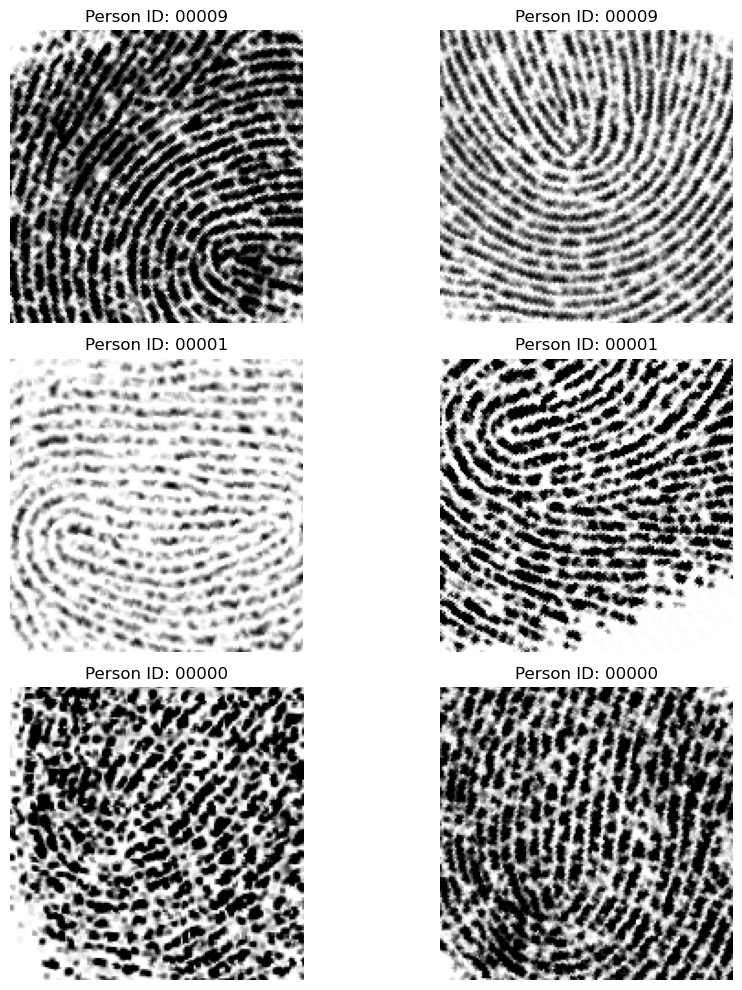

In [49]:
# Randomly sample some person IDs and their fingerprints
sample_images = []
for person_id in random.sample(os.listdir(train_dir), 3):  # Pick 3 random person IDs
    person_path = os.path.join(train_dir, person_id)
    if os.path.isdir(person_path):
        # Pick 2 random images for each person
        sample_images += [(person_id, os.path.join(person_path, img)) 
                          for img in random.sample(os.listdir(person_path), 2)]

# Plot the samples
plt.figure(figsize=(10, 10))
for i, (person_id, img_path) in enumerate(sample_images, 1):
    img = Image.open(img_path)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap="gray")  # raw data is grayscale images
    plt.title(f"Person ID: {person_id}")
    plt.axis("off")
    print(f"Image: {img_path}, Dimensions: {img.size}")  # Print dimensions

plt.tight_layout()
plt.show()

# Exercise: Train a CNN from scratch to correctly identify the person a fingerprint belongs to
We want to train a model that can classify a fingerprint image as the correct person. This is a multi-class problem (as opposesd to a binary classification problem e.g. Hotdog/not hotdog). Keep in mind that we will need to evaluate this model a bit differently than we do for a binary classification problem. 

## Data Pre-processing
- resize images to be the same *(160, 160)*
- normalize
- convert to grayscale
- save as a numpy array for input into the CNN

In [50]:
def load_and_preprocess_images(image_paths):
    '''
     Load and preprocess grayscale fingerprint images for input into a CNN model. 
     '''
    images = []
    labels = []
    for person_id in os.listdir(image_paths):
        person_path = os.path.join(image_paths, person_id)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                # Load the image
                img = image.load_img(img_path, target_size=(160, 160), color_mode="grayscale")
                # Convert the image to a NumPy array
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(int(person_id))  

    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_and_preprocess_images(train_dir)
train_images = np.array(train_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
train_labels = to_categorical(train_labels)

val_images, val_labels = load_and_preprocess_images(val_dir)
val_images = np.array(val_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
val_labels = to_categorical(val_labels)

test_images, test_labels = load_and_preprocess_images(test_dir)
test_images = np.array(test_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
test_labels = to_categorical(test_labels)

In [51]:
train_images.shape

(550, 160, 160, 1)

In [52]:
train_labels.shape

(550, 10)

## Create a CNN model architecture

In [70]:
final_Dense_units = 10
model_name = 'SubjectIDClassifier'

model_tb = Sequential(name=model_name)

model_tb.add(keras.layers.Input(shape=(160, 160, 1), dtype='float32'))
model_tb.add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_tb.add(layers.BatchNormalization())
model_tb.add(layers.MaxPool2D((2, 2)))
model_tb.add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_tb.add(layers.BatchNormalization())
model_tb.add(layers.MaxPool2D((2, 2)))
model_tb.add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_tb.add(layers.BatchNormalization())
model_tb.add(layers.MaxPool2D((2, 2)))
model_tb.add(layers.Dropout(0.5))
model_tb.add(layers.Flatten())
model_tb.add(layers.Dense(256, activation='relu'))
model_tb.add(layers.Dropout(0.4))
model_tb.add(layers.Dense(final_Dense_units, activation='softmax'))

# Complete with Adam optimizer and entropy cost
model_tb.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model_tb.summary()

Model: "SubjectIDClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 156, 156, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 156, 156, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 78, 78, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 74, 74, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 74, 74, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 35, 35, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 35, 35, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       9,470,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,599,626 (36.62 MB)

 Trainable params: 9,599,178 (36.62 MB)

 Non-trainable params: 448 (1.75 KB)

## Set Hyperparameters:
- Set the **epochs**
- Set the **batch_size**

### Callbacks
- Callbacks in Keras are objects that are called at different points during training (at the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They can be used to implement certain behaviors, such as:

- Doing validation at different points during training (beyond the built-in per-epoch validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to fit():


In [75]:
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64

CallBack = [
        callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
            ),
         callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
       #  callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr, verbose=1),
]
            
            #monitor='val_accuracy', patience=5, mode='max', verbose=1),
        #callbacks.TensorBoard(log_dir="./log_dir/"+model_name)
#  callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr, verbose=1),

## Train (fit) the model 
**Fit** the model to the training data that you just prepared and use the validation data to evaluate the model.
- HINT: see the **validation_data** parameter for the *.fit* method)

In [76]:
history = model_tb.fit(train_images, 
                          train_labels,
                          batch_size = batch_size,
                          epochs = epochs, 
                          validation_data = (val_images, val_labels),
                          verbose = 1, 
                          callbacks= CallBack
                         )


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6049 - loss: 1.2672 - val_accuracy: 0.1417 - val_loss: 3.6697
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6885 - loss: 1.0379 - val_accuracy: 0.1667 - val_loss: 3.9336
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7185 - loss: 0.9506 - val_accuracy: 0.1750 - val_loss: 4.4709
Epoch 3: early stopping


## Saving your model (optional)
Saving a model is straightforward, it can be done with the *pickle* library, or the *h5* library, or the keras native format. 

In [31]:
model_tb.save("subjectIDClassifier_1.keras")

# Exercise: Fingerprint Authentication
Create an additional function that will take in a raw .bmp image of a fingerprint, predict the ownder's ID, and validate whether the model has correctly predicted the owner. 

In [117]:
def register_fingerprint(image_path, model):

    # Load the image
    #img_resized = image.load_img(img_path, target_size=(160, 160), color_mode="grayscale")
    # Convert the image to a NumPy array
    #img_array = image.img_to_array(img_resized)
    img_final = image_path.reshape(-1, 160, 160, 1).astype('float32') / 255.0

    # Predict the fingerprint features
    features = model.predict(img_final)

    # Save the features
    features = features.flatten()
    with open('fingerprint_features.pickle', 'wb') as f:
        pickle.dump(features, f)

def authenticate_fingerprint(image_path):
    
    # Load the image
    #img_resized = image.load_img(img_path, target_size=(160, 160), color_mode="grayscale")
    # Convert the image to a NumPy array
    #img_array = image.img_to_array(img_resized)
    img_final = image_path.reshape(-1, 160, 160, 1).astype('float32') / 255.0

    # Predict the fingerprint features
    features = model.predict(img_final)

    # Compare the features
    with open('fingerprint_features.pickle', 'rb') as f:
        known_features = pickle.load(f)

    # Use the distance function to compare the features
    dist = np.linalg.norm(features - known_features, axis=1)

    # Authentication result
    if dist < 0.01:
        return True
    else:
        return False

In [118]:
# Register the fingerprint features
image = test_images[2]
register_fingerprint(image, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [119]:
# Authenticate the fingerprint
is_authenticated = authenticate_fingerprint(image)

# Print the authentication result
print(is_authenticated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
True


# Exercise 2: Using a pre-trained model using Keras
We can utilize a pre-trained image model to make it easier for our model to learn our dataset. VGG is an classic image model that was trained to classify images during the infamous ImageNet Challenge 2014. What we will do is **transfer** this knowledge from the VGG model to our model by **fine-tuning** the last few layers to our data. 

Prepare the images. this time we will not use grayscale b/c this model has been trained on color images and the color could have additional information. 
- load and size the images
- convert to a numpy array
- use RGB (instead of converting to grayscale)
- Normalize

In [54]:
def load_and_preprocess_images_color(image_paths):
    '''
     Load and preprocess grayscale fingerprint images for input into a CNN model. 
     '''
    images = []
    labels = []
    for person_id in os.listdir(image_paths):
        person_path = os.path.join(image_paths, person_id)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                # Load the image
                img = image.load_img(img_path, target_size=(160, 160), color_mode="grayscale")
                # Convert the image to a NumPy array
                img_array = image.img_to_array(img)
                img_array = np.repeat(img_array, 3, axis=-1) / 255.0 
                
                images.append(img_array)
                labels.append(int(person_id))  

    return np.array(images), np.array(labels)

In [69]:
# Load and process image data for input into CNN
train_images, train_labels = load_and_preprocess_images_color(train_dir)
#train_images = np.array(train_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
#train_labels = to_categorical(train_labels)

val_images, val_labels = load_and_preprocess_images_color(val_dir)
#val_images = np.array(val_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
#val_labels = to_categorical(val_labels)

test_images, test_labels = load_and_preprocess_images_color(test_dir)
#test_images = np.array(test_images).reshape(-1, 160, 160, 1).astype('float32') / 255.0
#test_labels = to_categorical(test_labels)

In [70]:
train_images.shape

(550, 160, 160, 3)

In [71]:
train_labels.shape

(550,)

## Use a VGG pre-trained model
### Download model weights
- DownLoad VGG16 weights without the top layer

We exclude the fully connected layers by setting **include_top=False** because we want to replace (**fine-tune**) this with our task (data and 10 classes/labels). 


In [72]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

### Initialize base model
#### Freezing layers
If we use the default weights when adding our layer, the first iteration will be very inaccurate which will create a large gradient. 
Remember, we are using backpropagation which will send these huge errors back to the lower level (nice pre-trained layers) which will mess it all up. 

To keep these lower-level features preserved, we can freeze the base model layers, until our new layers have become more stable. 

In [73]:
# Freeze the base layers
base_model.trainable = False

In [79]:
# Build the model architecture that will be specific to our data and task
model_pre_trained = models.Sequential([
    base_model, #frozen pre-trained model
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes for fingerprint identification of 10 people
])

# Compile the model
model_pre_trained.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### Overfitting
Reduce the overfitting by implementing **EarlyStopping**

In [80]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Train the model 
- Use the pre-trained base_model weights initialized above and fit it to our training/validation data.

Notice where the model starts this time in terms of accuracy, and how/if it improves w/ each epoch

In [76]:
# Train the model
model_pre_trained.fit(train_images, train_labels, epochs=10, batch_size=32, 
                      validation_data=(val_images, val_labels), 
                      callbacks=[early_stopping])

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.0986 - loss: 2.6233 - val_accuracy: 0.1083 - val_loss: 2.3098
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.1179 - loss: 2.4170 - val_accuracy: 0.1583 - val_loss: 2.2399
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.1048 - loss: 2.3240 - val_accuracy: 0.3667 - val_loss: 2.1967
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.1445 - loss: 2.2704 - val_accuracy: 0.3167 - val_loss: 2.1613
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.2209 - loss: 2.1899 - val_accuracy: 0.3917 - val_loss: 2.1224
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.2397 - loss: 2.1772 - val_accuracy: 0.4917 - val_loss: 2.0874
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.2316 - loss: 2.1059 - val_accuracy: 0.4750 - val_loss: 2.0534
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.2853 - loss: 2.0974 - val_accuracy: 0.5583 - val_loss

In [80]:
# Evaluate on the test set
test_loss, test_acc = model_pre_trained.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5509 - loss: 1.9382
Test Loss: 1.9373334646224976
Test Accuracy: 0.5692307949066162


Fit the model again

In [82]:
# Train the model
model_pre_trained.fit(train_images, train_labels, epochs=30, batch_size=32, 
          validation_data=(val_images, val_labels), 
          callbacks=[early_stopping])

18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.3410 - loss: 1.9464 - val_accuracy: 0.5583 - val_loss: 1.9173


In [83]:
# Evaluate the model on the test set
test_images, test_labels = load_and_preprocess_images(test_dir)  # Load test data

# Evaluate on the test set
test_loss, test_acc = model_pre_trained.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5854 - loss: 1.9035
Test Loss: 1.9048576354980469
Test Accuracy: 0.6000000238418579


Now fit the model again and choose:
- number of **epochs**
- **batch_size**

Notice what is happening to the accuracy and loss for the train and validation sets as the model continues to train. 

## Saving your model (optional)
Saving a model is straightforward, it can be done with the *pickle* library, or the *h5* library. 

In [ ]:
# Save the model 
model.save('fingerprint_model.h5')

## Loading your model 
If you want to load the model you trained, use the code below

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('fingerprint_model.h5')